In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import datetime
import warnings
import time
from scipy import stats
from sklearn import linear_model
import itertools
import calendar
warnings.filterwarnings('ignore')
import re
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV,learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pickle as pk

## Load the data sample via pkl

In [4]:
df = pk.load(open('data_sample.pkl','rb'))

## Run Regression: Setting up a predictive model for run duration prediction.

#### Using a ridge regression for regularize the model to reduce complexity
##### Redundant metrics: BMI and weight - only using weight

In [5]:
X = df[['Steps', 'Sleep', 'Avg Heart Rate','Weight', 'Body Fat', 'Run Distance']]
y = df[['Run Duration']]

In [6]:
# The actual model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=4)
ridge = Ridge(alpha=.3, normalize=True) 
ridge.fit(X_train, y_train)

Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [ ]:
import pickle as pk
pk.dump(ridge, open('ridge.pkl','wb'))

In [7]:
score = ridge.score(X_train, y_train)
print('R-square')
print(score)

R-square
0.858483421754


#### Ridge Regression Coefficient Path

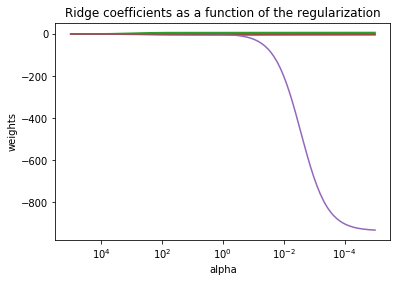

In [9]:
y2 = y.values
y3 = y2.reshape(112,)
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y3)
    coefs.append(ridge.coef_)

# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.legend()
plt.show()

### Cross Validation

In [10]:
cv_results = cross_val_score(ridge, X_train, y_train, cv=10)
cvscore = np.mean(cv_results)
cvstd = np.std(cv_results)
print('R-square')
print(cvscore)
print('standard deviation')
print(cvstd)

R-square
0.880916565971
standard deviation
0.10315623403


In [11]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure(dpi=500)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.ylim(0, None)
    plt.grid()
    
    return plt

<module 'matplotlib.pyplot' from '/Users/DAlfego/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

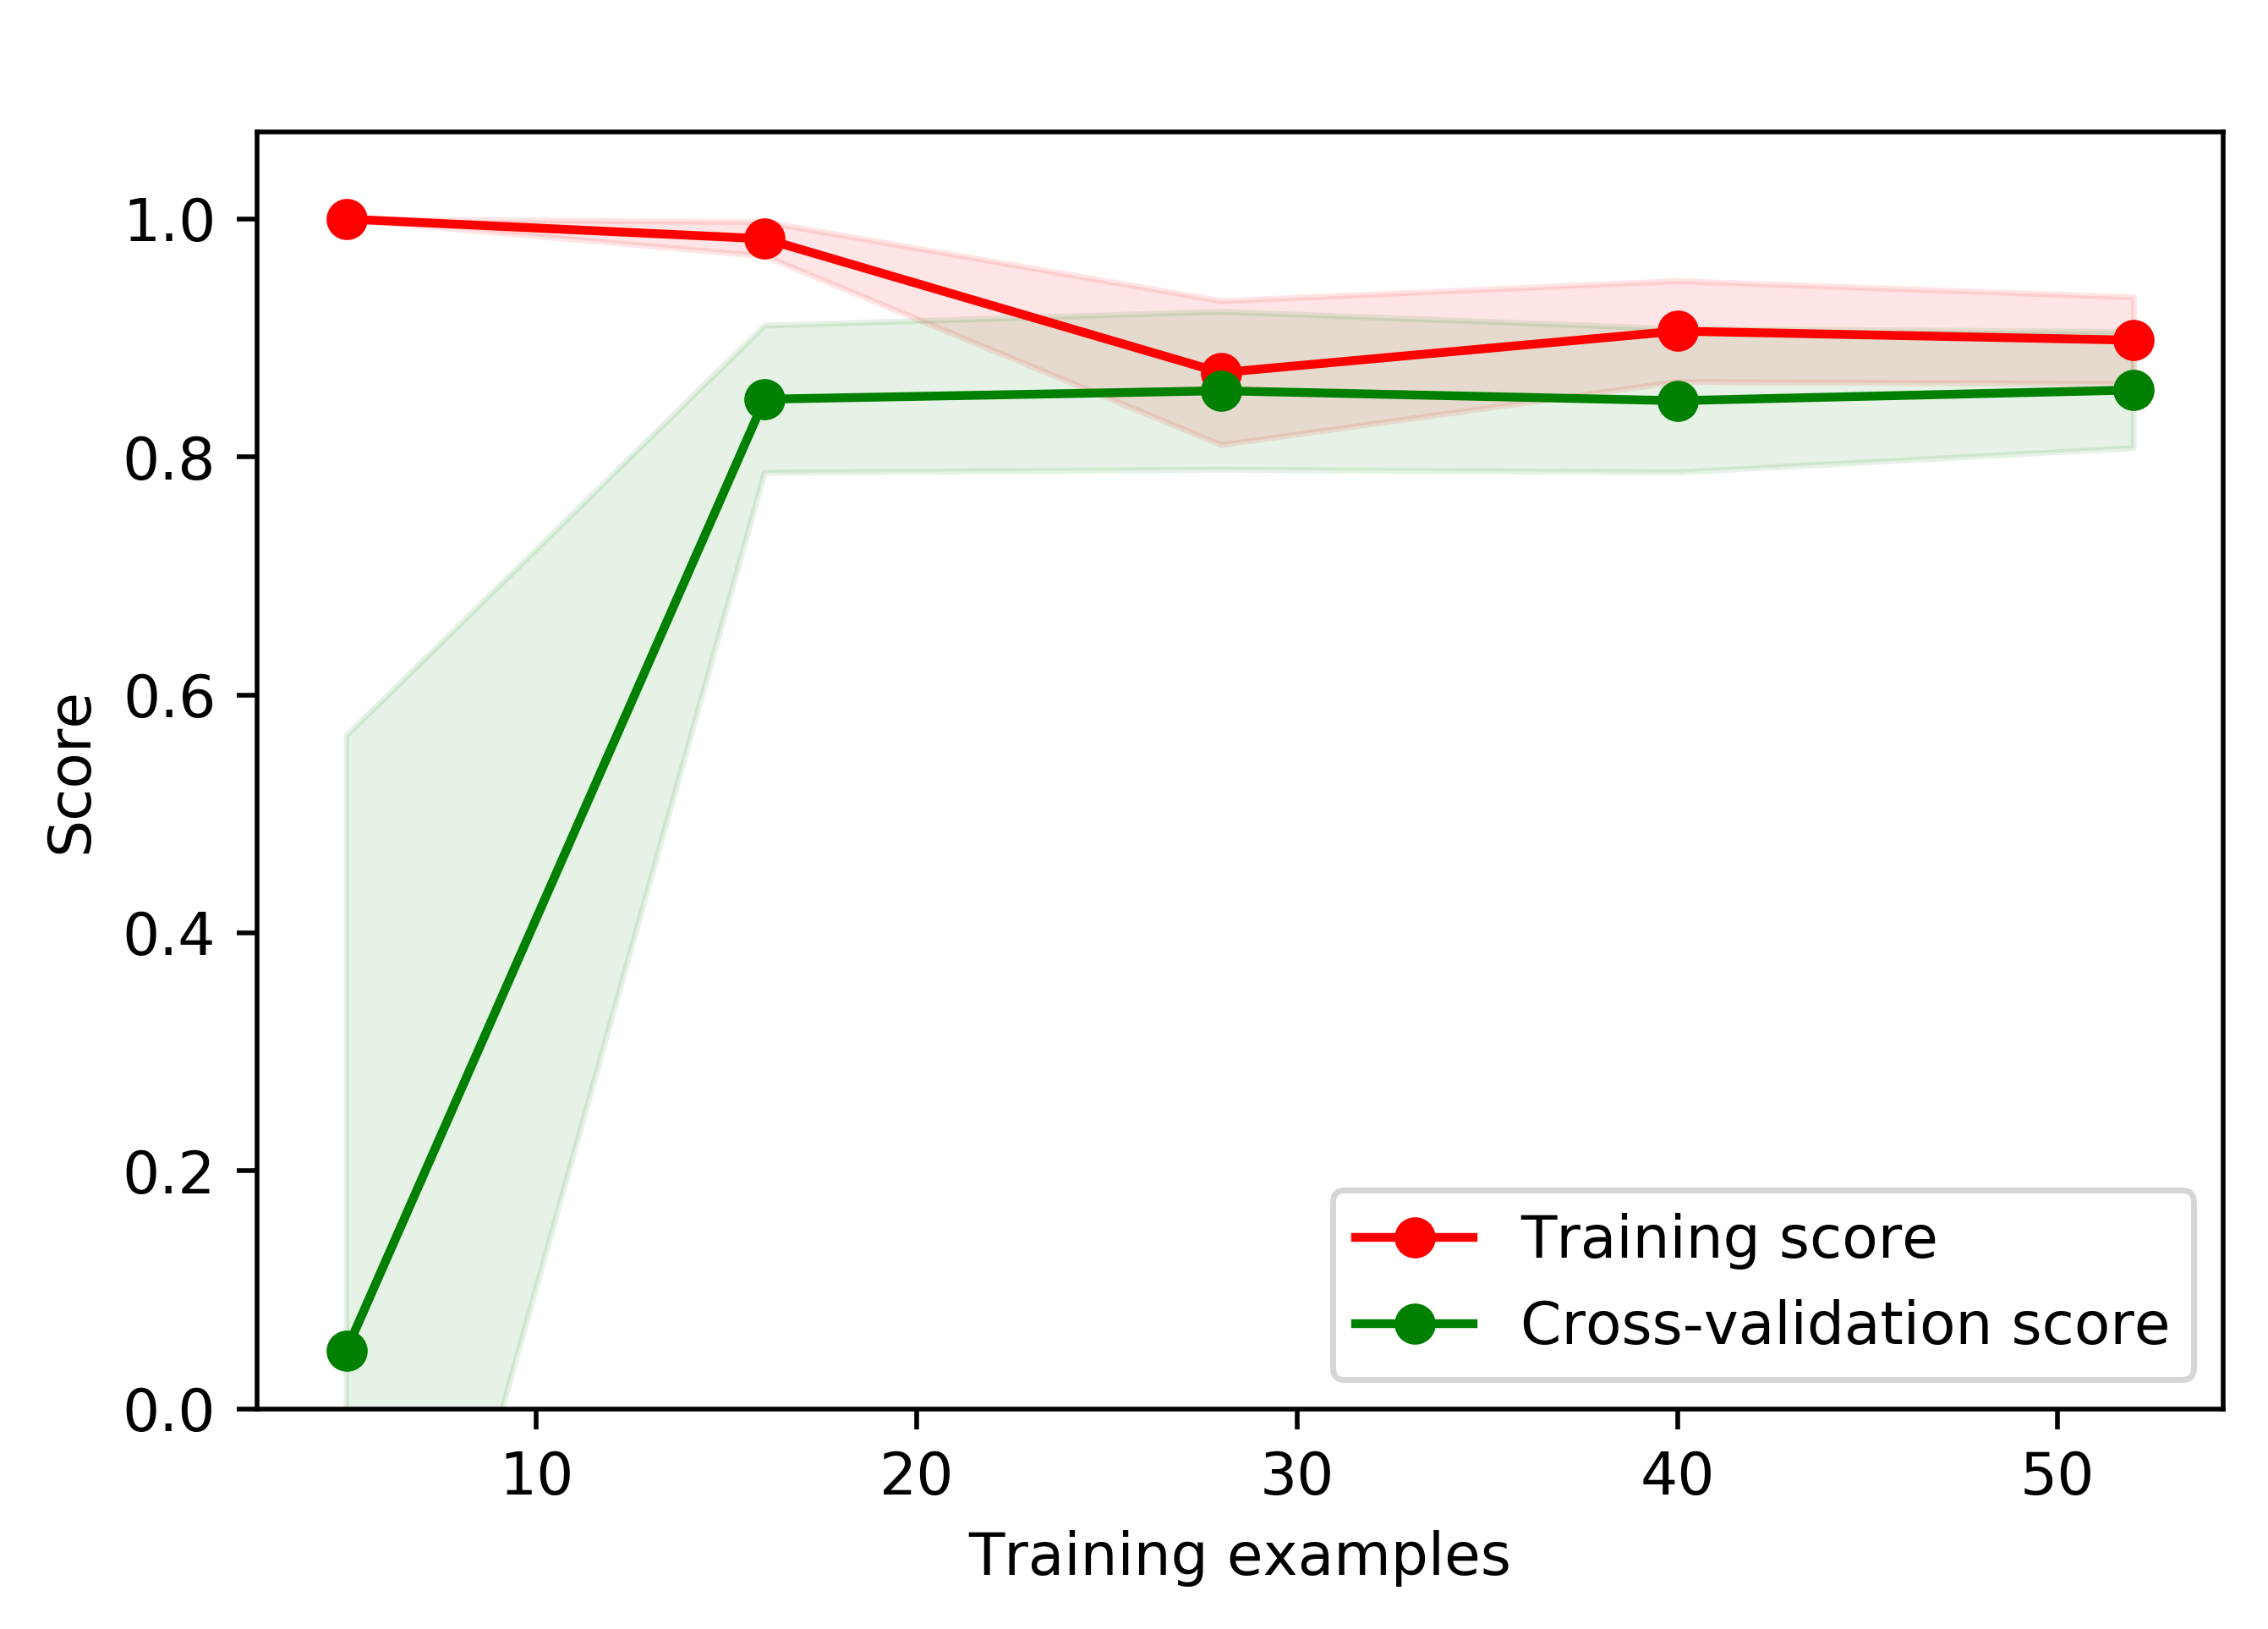

In [12]:
plot_learning_curve(ridge, ' ', X_train, y_train, n_jobs=2)

## Example of run prediction
### Definition of the user's goals:
#### steps = amount of steps desired to walk, sleep = amount of sleep you would like to achieve, hr = projected average heart rate, weight, bf = current body fat percentage, and pace_min = minutes/mile run pace with pace_sec = amount of seconds in that pace (i.e an 8min30sec/mile pace: pace_min=8, pace_sec=30)

In [15]:
def runpredictor(steps, sleep, hr, weight, bf, pace_min, pace_sec):
    steps = int(steps)
    hr = int(hr)
    weight = int(weight)
    bf = int(bf)
    sleep = int(sleep)
    run_distance = 0
    run_distance = int(run_distance)
    pace_min = int(pace_min)
    pace_sec = int(pace_sec)
    
    goals = pd.DataFrame([steps, hr, weight, bf, sleep, run_distance])
    goals = goals.transpose()
         
    prediction = ridge.predict(goals)
    prediction = int(prediction[0])-15
    pred2 = divmod(prediction, 60)
    prediction_hrs = pred2[0]
    prediction_min = pred2[1]
    
    pace_convert = pace_min + pace_sec/60
    distance = prediction/pace_convert
    distance = round(distance,1)
    
    if prediction < 59:
        pred_output_str = '{} minutes'.format(prediction)
        pace_output_str = 'At your pace, that will be: {} miles'.format(distance)
        return pred_output_str, pace_output_str
    elif prediction >= 60 & prediction_hrs < 1:
        pred_output_str = '{} hour and {} minutes'.format(prediction_hrs, prediction_min)
        pace_output_str = 'At your pace, that will be: {} miles'.format(distance)
        return pred_output_str, pace_output_str
    elif prediction >= 60 & prediction_hrs > 1:
        pred_output_str = '{} hours and {} minutes'.format(prediction_hrs, prediction_min)
        pace_output_str = 'At your pace, that will be: {} miles'.format(distance)
        return pred_output_str, pace_output_str
    return predint

#### For a user who wants to reach: 10,000 steps, an average heart rate of 75 bpm, 7 hrs of sleep, weighs 150 lbs and 20% body fat and runs an 8min 30sec / mile pace:

In [16]:
runpredictor(10000,7,75,150,20,8,30)

('34 minutes', 'At your pace, that will be: 4.0 miles')

#### A deeper look

Text(0.5,0,'Fitted')

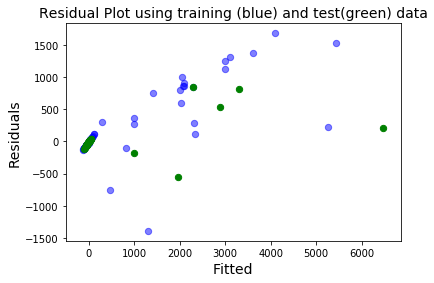

In [17]:
X2 = X_test[X_test.index != '2017-10-21']
X3 = X2[X2.index != '2017-10-13']

y2 = y_test[y_test.index != '2017-10-21']
y3 = y2[y2.index != '2017-10-13']

fig = plt.scatter(ridge.predict(X_train), ridge.predict(X_train) - y_train['Run Duration'], c='b', s=40, alpha=0.5)
fig = plt.scatter(ridge.predict(X3), ridge.predict(X3) - y3['Run Duration'], c='g', s=40)
plt.title('Residual Plot using training (blue) and test(green) data',fontsize=14)
plt.ylabel('Residuals',fontsize=14)
plt.xlabel('Fitted',fontsize=14)